In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io, feature, filters, transform, measure
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.measure import find_contours
from scipy import ndimage as ndi
import pickle

from scripts.utils import *
from scripts.chromatinSegmentation import thre_h_watershed
from scripts.chromatinMetrics import compute_chromatin_metrics

In [3]:
num = 1
home_path = "/groups/gaa50089/acd13264yb/disease_epigenome/results_RTT/Classification"
rett_type = "HPS9999"
ctrl_type = "RETT"
chip_type = "CTCF"
image_path = get_image_path(ctrl_type, chip_type, rett_type)
print(image_path)

# H3K27ac_labels = show_mask_and_metrics(ctrl_type, rett_type, "H3K27ac", num)
# CTCF_labels = show_mask_and_metrics(ctrl_type, rett_type, "CTCF", num)

RETT_HPS9999_CTCF


# Chromatin Centroids

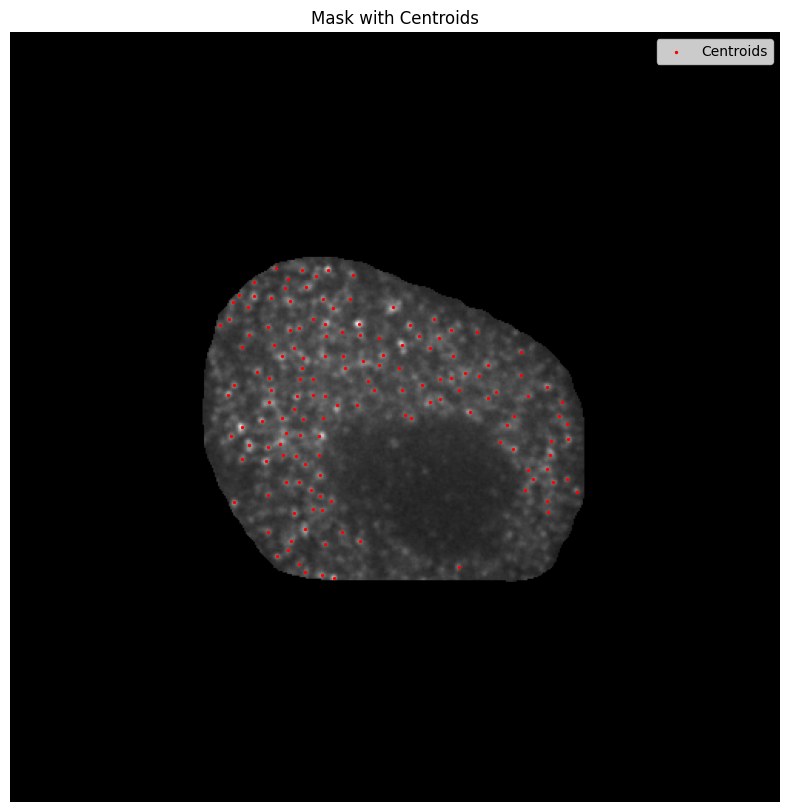

In [4]:
def chromation_centroid(cc_mask):
    """
    计算染色中心的质心。
    """
    cc_props = measure.regionprops(cc_mask)
    centroids = np.array([prop.centroid for prop in cc_props])
    centroids = np.round(centroids).astype(int)
    return centroids

image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[0,:,:,0]
cc_labels = thre_h_watershed(image)   
centroids = chromation_centroid(cc_labels)

# 绘制H3K27ac掩膜和质点
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 1], centroids[:, 0], color='red', s=2, label='Centroids')
plt.title('Mask with Centroids')
plt.legend()
plt.axis('off')
plt.show()

# Distribution

In [4]:
def nucleus_intensity_distribution(image, centroids, num_parts=5, num_per_area=250):
    _, thresh = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)
    mask = thresh.copy()
    h, w = thresh.shape[:2]
    mask_gap = 255//num_parts
    
    for i in range(num_parts, 0, -1):
        scale = i/5
        new_h, new_w = int(h * scale), int(w * scale)
        d_h, d_w = (h - new_h) // 2, (w - new_w) // 2
        resized = cv2.resize(thresh, (new_w, new_h))
        copy = np.zeros_like(thresh)
        copy[d_h:d_h + new_h, d_w:d_w + new_w] = resized*2
        copy[copy == 0] = 1
        mask *= copy
        
    part_area = np.zeros(num_parts)
    part_centroids_num = np.zeros(num_parts)
    part_centroids_num_per_area = np.zeros(num_parts)
    
    for i in range(num_parts):
        mask[mask==2**(i+1)] = mask_gap*(i+1)
        part_area[i] += np.sum(mask==mask_gap*(i+1))

    for i in range(len(centroids)):
        part_num = mask[centroids[i, 0], centroids[i, 1]]//mask_gap
        part_centroids_num[part_num.astype(int)-1] += 1

    for i in range(num_parts):
        part_centroids_num_per_area[i] = part_centroids_num[i]*num_per_area/part_area[i]

#     # 绘制H3K27ac掩膜和质点
#     print(part_area)
#     print(part_centroids_num)
#     print(part_centroids_num_per_area)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(mask, cmap='gray')
#     plt.scatter(centroids[:, 1], centroids[:, 0], color='red', s=2, label='Centroids')
#     plt.title('H3K27ac Mask with Centroids')
#     plt.legend()
#     plt.axis('off')
#     plt.show()
    
    return part_centroids_num_per_area

In [5]:
part_centroids_num_per_area = nucleus_intensity_distribution(image, centroids)
print(part_centroids_num_per_area)

[0.81274382 0.92359362 1.16713352 0.58858152 0.58513751]


## Extract all - Chromatins distribution

In [6]:
# rett_type = "HPS9999"
# ctrl_type = "CTRL"
# chip_type = "H3K27ac"
# for chip_type in ["H3K27ac"]:
#     for ctrl_type in ["CTRL"]:
#         image_path = get_image_path(ctrl_type, chip_type, rett_type)
#         images = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)
#         print(image_path, images.shape)

#         all_part_centroids_num_per_area = []
#         for num in tqdm(range(len(images))):
#             image = images[num,:,:,0]

#             cc_labels = thre_h_watershed(image)   
#             centroids = chromation_centroid(cc_labels)

#             part_centroids_num_per_area = nucleus_intensity_distribution(image, centroids, num_parts=5, num_per_area=100)
#             all_part_centroids_num_per_area.append(part_centroids_num_per_area)

#         all_part_centroids_num_per_area=np.array(all_part_centroids_num_per_area)
#         print(all_part_centroids_num_per_area.shape)

#         with open(f'all_part_centroids_num_per_area_{image_path}.pkl', 'wb') as f:
#             pickle.dump(all_part_centroids_num_per_area, f)

# Co-Localization

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy.spatial import distance

def H3K27ac_centroids_ctcf_mindist(H3K27ac_mask, CTCF_mask):
    # 获取连通组件的质心
    H3K27ac_centroids = chromation_centroid(H3K27ac_mask)
    CTCF_centroids = chromation_centroid(CTCF_mask)

    # 计算每个H3K27ac粒子到最近的CTCF粒子的距离
    nearest_distances = []
    for h3_centroid in H3K27ac_centroids:
        distances = distance.cdist([h3_centroid], CTCF_centroids, 'euclidean')
        nearest_distance = np.min(distances)
        nearest_distances.append(nearest_distance)
    
    return nearest_distances

def H3K27ac_cirlce_ctcf_radius(H3K27ac_mask, CTCF_mask, maxradii=50):
    # 获取连通组件的质心
    H3K27ac_centroids = chromation_centroid(H3K27ac_mask)
    CTCF_centroids = chromation_centroid(CTCF_mask)

    # 设置要计算的不同半径范围
    radii = np.arange(0, maxradii, 1)  # 0到50像素，步长为5

    # 计算每个H3K27ac粒子不同半径范围内的CTCF粒子数量
    counts_per_radius = {radius: [] for radius in radii}

    for h3_centroid in H3K27ac_centroids:
        distances = distance.cdist([h3_centroid], CTCF_centroids, 'euclidean')[0]
        for radius in radii:
            count_within_radius = np.sum(distances <= radius)
            counts_per_radius[radius].append(count_within_radius)

    # 计算每个半径范围内的平均CTCF粒子数量
    average_counts_per_radius = {radius: np.mean(counts) for radius, counts in counts_per_radius.items()}
    
    return average_counts_per_radius 

## CTRL

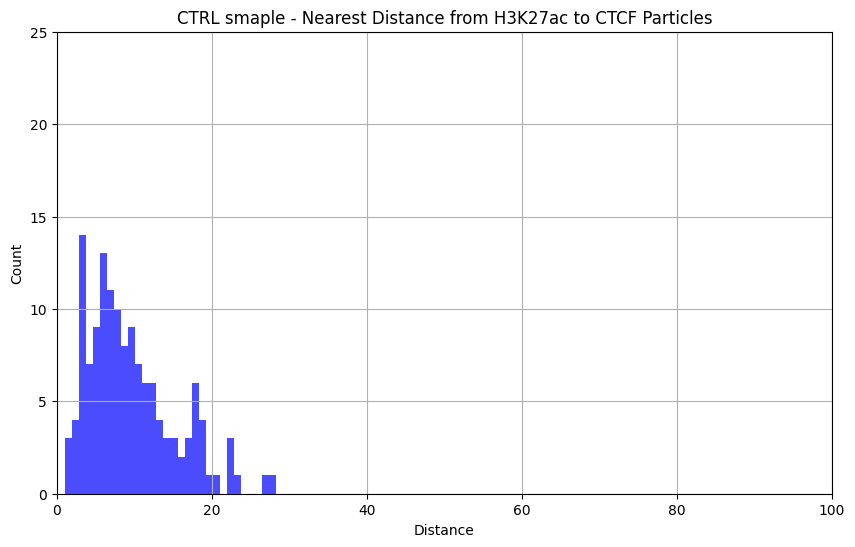

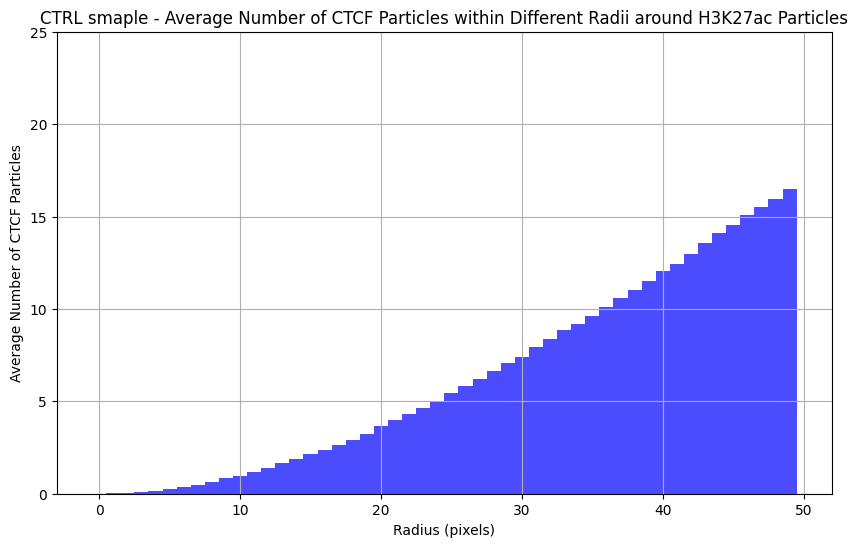

In [10]:
ctrl_type = "CTRL"

image_path = get_image_path(ctrl_type, "H3K27ac", "HPS9999")
image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[0,:,:,0]
H3K27ac_labels = thre_h_watershed(image)   

image_path = get_image_path(ctrl_type, "CTCF", "HPS9999")
image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[0,:,:,0]
CTCF_labels = thre_h_watershed(image)   

# nearest_distances = H3K27ac_centroids_ctcf_mindist(H3K27ac_labels, CTCF_labels)
nearest_distances = H3K27ac_centroids_ctcf_mindist(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.hist(nearest_distances, bins=30, color='blue', alpha=0.7)
plt.title('CTRL smaple - Nearest Distance from H3K27ac to CTCF Particles')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.xlim(0,100)
plt.ylim(0,25)
plt.grid(True)
plt.show()
    
# average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(H3K27ac_labels, CTCF_labels)
average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.bar(average_counts_per_radius.keys(), average_counts_per_radius.values(), width=1, color='blue', alpha=0.7)
plt.title('CTRL smaple - Average Number of CTCF Particles within Different Radii around H3K27ac Particles')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Number of CTCF Particles')
plt.ylim(0,25)
plt.grid(True)
plt.show()

## RTT

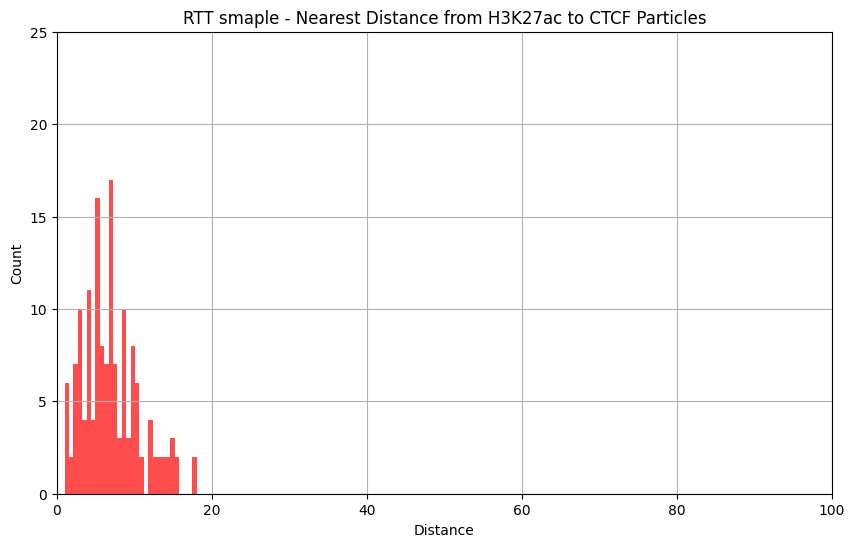

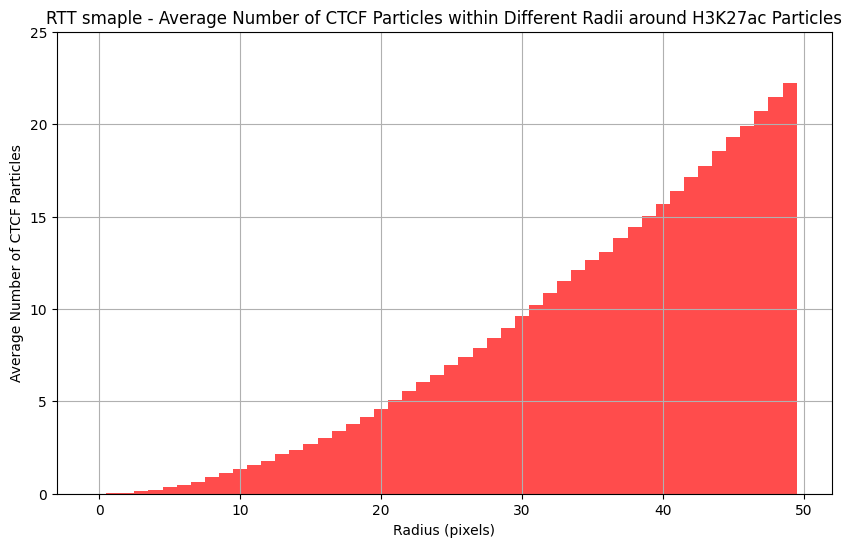

In [17]:
ctrl_type = "RETT"

image_path = get_image_path(ctrl_type, "H3K27ac", "HPS9999")
image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[0,:,:,0]
H3K27ac_labels = thre_h_watershed(image)   

image_path = get_image_path(ctrl_type, "CTCF", "HPS9999")
image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[0,:,:,0]
CTCF_labels = thre_h_watershed(image)   

# nearest_distances = H3K27ac_centroids_ctcf_mindist(H3K27ac_labels, CTCF_labels)
nearest_distances = H3K27ac_centroids_ctcf_mindist(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.hist(nearest_distances, bins=30, color='red', alpha=0.7)
plt.title('RTT smaple - Nearest Distance from H3K27ac to CTCF Particles')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.xlim(0,100)
plt.ylim(0,25)
plt.grid(True)
plt.show()
    
# average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(H3K27ac_labels, CTCF_labels)
average_counts_per_radius = H3K27ac_cirlce_ctcf_radius(CTCF_labels, H3K27ac_labels)
plt.figure(figsize=(10, 6))
plt.bar(average_counts_per_radius.keys(), average_counts_per_radius.values(), width=1, color='red', alpha=0.7)
plt.title('RTT smaple - Average Number of CTCF Particles within Different Radii around H3K27ac Particles')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Number of CTCF Particles')
plt.ylim(0,25)
plt.grid(True)
plt.show()

# Extract all #nearest_distances and #average_counts_per_radius

In [16]:
max_area = 1000
maxradii = 500

In [21]:
 def compute_co_location_metrics(H3K27ac_mask, CTCF_mask):

    H3K27ac_centroids = chromation_centroid(H3K27ac_mask)
    CTCF_centroids = chromation_centroid(CTCF_mask)

    metrics = {}
    metrics['h3k27ac2ctcf_mindist'] = H3K27ac_centroids_ctcf_mindist(H3K27ac_centroids, CTCF_centroids)
    metrics['h3k27ac2ctcf_radius'] = H3K27ac_cirlce_ctcf_radius(H3K27ac_centroids, CTCF_centroids)
    metrics['ctcf2h3k27ac_mindist'] = H3K27ac_centroids_ctcf_mindist(CTCF_centroids, H3K27ac_centroids)
    metrics['ctcf2h3k27ac_radius'] = H3K27ac_cirlce_ctcf_radius(CTCF_centroids, H3K27ac_centroids)
    
    return metrics

In [22]:
rett_type = "CTRL"

H3K27ac_images = np.load(f"{home_path}/Datasets/{rett_type}_H3K27ac.npy", allow_pickle=True)[:,:,:,0]
CTCF_images = np.load(f"{home_path}/Datasets/{rett_type}_CTCF.npy", allow_pickle=True)[:,:,:,0]

metrics_co_localization = {
    "h3k27ac2ctcf_mindist":[],
    "h3k27ac2ctcf_radius": [],
    "ctcf2h3k27ac_mindist":[],
    "ctcf2h3k27ac_radius": []
}

for num in tqdm(range(2)):

    H3K27ac_mask = thre_h_watershed(H3K27ac_images[num], min_distance=5, max_area=max_area)
    CTCF_mask = thre_h_watershed(CTCF_images[num], min_distance=5, max_area=max_area)
    
    metrics = compute_co_location_metrics(H3K27ac_mask, CTCF_mask)
    metrics_co_localization["h3k27ac2ctcf_mindist"].append(metrics["h3k27ac2ctcf_mindist"])
    metrics_co_localization["h3k27ac2ctcf_radius"].append(metrics["h3k27ac2ctcf_radius"])
    metrics_co_localization["ctcf2h3k27ac_mindist"].append(metrics["ctcf2h3k27ac_mindist"])
    metrics_co_localization["ctcf2h3k27ac_radius"].append(metrics["ctcf2h3k27ac_radius"])

with open(f'metrics_co_localization_{rett_type}.pkl', 'wb') as f:
    pickle.dump(metrics_co_localization, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.94it/s]
